<br><br>
<h1 style="font-size:36px" align="center">Tree data creation</h1><br><br><br><br><br><br>

## Gets the following information to display on the tree:

#### 1. Sequence Taxonomy and Color associated to the taxonomy
#### 2. Identify reference sequences (known properties) in the list of sequences
#### 3. Identify characteristic properties of the sequences:
- TfuA nearby
- E1 domains within the protein
- Other characteristic proteins


In [8]:
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO
import copy
import json
import os
import csv
import tqdm
import re
import math
all_annotations_filename = "../raw_sequences/interpro_all_YcaO_annotated.json"
tridomain_annotations_filename = "../raw_sequences/cyclodehydratase_annotaded_sequences.json"
rodeo_dir = "../raw_sequences/RODEO_data/"
headers = []
data = []

def add_data(header,d):
    headers.append(header)
    data.append(d)

<br>

## Load sequences, accessions and annotations.
<br><br>

In [2]:
base_dir = "../processed_sequences/clustal_hmm_5_per_cluster_18022023/"
tree_sequences_filename = os.path.join(base_dir,"seqs11.txt")

sequences = [seq for seq in SeqIO.parse(tree_sequences_filename,"fasta")]
for seq in sequences:
    seq.seq = Seq("".join(str(seq.seq).split("-")))
    new_id = seq.id.split("/")[0]
    seq.id = new_id
    seq.description = new_id
    seq.name = new_id
    
sequence_accessions = [seq.id for seq in sequences]
add_data("accession",sequence_accessions)

YcaO_data = []
with open(all_annotations_filename, 'r') as f:
    YcaO_data = json.load(f)
    
    
E1_data = []
with open(tridomain_annotations_filename, 'r') as f:
    E1_data = json.load(f)

In [3]:
def get_item_by_accession(seqs, accession):
    for item in seqs:
        if item['Accession_Interpro'] == accession.split(".")[0]:
            return item
    return None
def get_item_by_RefSeq_accession(seqs, accession):
    for item in seqs:
        if item['Accession_RefSeq'] == accession.split(".")[0]:
            return item
    return None

In [4]:
#Load RODEO data
rodeo_files = []
for subdir, dirs, files in os.walk(rodeo_dir):
    for file in files:
        if file.endswith("main_co_occur.csv"):
            rodeo_files.append(os.path.join(subdir, file))
            
rodeo_data = []
for file in rodeo_files:
    with open(file) as csvfile:
        reader = csv.DictReader(csvfile)
        rows = [row for row in reader]
        rodeo_data.extend(rows)

        
processed_rodeo_data = {}
for i in tqdm.tqdm(range(0,len(rodeo_data)),desc="Processing Rodeo Data"):
    row = rodeo_data[i]
    if(row["Query"] not in processed_rodeo_data):
        processed_rodeo_data[row["Query"]] = []
    contents = []
    #print(row)
    for key, value in row.items():
        if key is not None:
            if "PfamID" in key and value is not None:
                contents.append(value)
        elif isinstance(value,list):
            for v in value:
                if re.search(r'PF\d{5}', v):
                    contents.append(v)
    processed_rodeo_data[row["Query"]].extend(contents)

def get_sequence_ID_present(Pfam_ID):
    RefSeq_ids_with_ID = []
    RefSeq_ids_without_ID = []
    for key, value in processed_rodeo_data.items():
        if Pfam_ID in value:
            RefSeq_ids_with_ID.append(key)
        else:
            RefSeq_ids_without_ID.append(key)

    sequence_ID_present = []

    for i in tqdm.tqdm(range(0,len(sequence_accessions)),desc=f"Scanning sequences for {Pfam_ID}"):
        accession = sequence_accessions[i]
        accession_data = get_item_by_accession(YcaO_data, accession)
        ID_present = "U"
        if("Accession_RefSeq" in accession_data):
            refSeq = accession_data["Accession_RefSeq"]
            if(refSeq in RefSeq_ids_with_ID):
                ID_present = "Y"
            elif(refSeq in RefSeq_ids_without_ID):
                ID_present = "N"
        sequence_ID_present.append(ID_present)
    return sequence_ID_present

sequence_TfuA_present = get_sequence_ID_present("PF07812")
sequence_ThiF_present = get_sequence_ID_present("PF00899")#IPR02291
#sequence_E1_present = get_sequence_ID_present("PF00676")#TIGR03603 but I can't find that on Pfam
#Potentially get FMN dependent YcaOs
add_data("TfuA_nearby",sequence_TfuA_present)
add_data("Ocin-ThiF_nearby",sequence_ThiF_present)

Scanning sequences for PF00899: 100%|██████████| 4839/4839 [00:05<00:00, 952.26it/s] 


In [5]:
taxonomy_index = 0
sequence_taxonomy = [get_item_by_accession(YcaO_data,accession)["lineage"][taxonomy_index].replace(" ", "_") for accession in sequence_accessions]
add_data("taxa", sequence_taxonomy)

In [6]:
import random
import colorsys
import matplotlib

def generate_colors(sequence_taxonomy):
    unique_taxa = set(sequence_taxonomy)
    taxa_colors = {}
    sequence_colors = []
    predefined_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    color_index = 0
    for taxa in unique_taxa:
        if color_index < len(predefined_colors):
            taxa_colors[taxa] = predefined_colors[color_index]
            color_index += 1
        else:
            h, s, v = random.random(), 0.5 + random.random() / 2.0, 0.4 + random.random() / 5.0
            r, g, b = colorsys.hsv_to_rgb(h, s, v)
            taxa_colors[taxa] = '#{:02x}{:02x}{:02x}'.format(int(r * 255), int(g * 255), int(b * 255))
    for taxa in sequence_taxonomy:
        sequence_colors.append(taxa_colors[taxa])
    return sequence_colors


sequence_colors = generate_colors(sequence_taxonomy)
add_data("color",sequence_colors)

In [7]:
import os
overwrite = True

# define the starting directory
root_dir = "../raw_sequences"

# create an empty list to store the file paths
fasta_paths = []

# use os.walk to iterate through all the subdirectories
for dirpath, dirnames, filenames in os.walk(root_dir):
    # iterate through the files in the current directory
    for file in filenames:
        # check if the file name is "fasta.fa" (case-insensitive)
        if  "fasta.fa" in file.lower():
            # construct the full path of the file
            fasta_path = os.path.join(dirpath, file)
            # append the path to the list
            fasta_paths.append(fasta_path)


db_dir = os.path.join(base_dir,"db_data/")
db_filename = os.path.join(db_dir,"my_blast_db")
db_sequences_filename = os.path.join(db_dir,"db_sequences.fa")


if not os.path.exists(db_dir):
    os.mkdir(db_dir)
    SeqIO.write(sequences, db_sequences_filename, "fasta")
    !makeblastdb -in {db_sequences_filename} -dbtype prot -out {db_filename}
else:
    if overwrite:
        print("Overwriting previous DB instance")
        !rm -rf $db_dir
        os.mkdir(db_dir)
        SeqIO.write(sequences, db_sequences_filename, "fasta")
        !makeblastdb -in {db_sequences_filename} -dbtype prot -out {db_filename}
    else:
        print("db_data folder already exists.")

import subprocess

path_accessions = []
for i in range(len(fasta_paths)):
    fasta_path = fasta_paths[i]
    print(f"{i+1}/{len(fasta_paths)} Processing {fasta_path}")
    path_parts = fasta_path.split("/")
    shortened_path = path_parts[2] + "_" + path_parts[3] + (("_" + path_parts[4]) if "fasta" not in path_parts[4].lower() else "")
    output = subprocess.run(f"blastp -db {db_filename} -query {fasta_path} -outfmt '6 sseqid' -max_target_seqs 1 -evalue 1e-20", shell=True, capture_output=True)
    accession_numbers = output.stdout.decode().strip().split("\n")
    print(f"Got results:\n{accession_numbers}")
    path_accessions.append((shortened_path, accession_numbers))

for path in path_accessions:
    for i in range(0,len(path[1])):
        path[1][i] = path[1][i].split("/")[0]   


Overwriting previous DB instance


Building a new DB, current time: 02/19/2023 23:53:12
New DB name:   /files/src/processed_sequences/clustal_hmm_5_per_cluster_18022023/db_data/my_blast_db
New DB title:  ../processed_sequences/clustal_hmm_5_per_cluster_18022023/db_data/db_sequences.fa
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 4839 sequences in 0.0707271 seconds.


1/27 Processing ../raw_sequences/Amidine/Jesko_but_unknown_outgroup_POTENTIALLY_IGNORE_DUE_TO_WEIRD_ALIGNMENT/outgroup_sequence_Fasta.fa
Got results:
['A0A0B5EGT3']
2/27 Processing ../raw_sequences/Amidine/Jesko_but_unknown/Fasta.fa
Got results:
['']
3/27 Processing ../raw_sequences/Amidine/Bottromycin/Fasta.fa
Got results:
['K4MHF8']
4/27 Processing ../raw_sequences/Unknown/EcYcaO/Fasta.fa
Got results:
['A0A376MUM2']
5/27 Processing ../raw_sequences/Azoline/Thiopeptides/Thiopeptide_Lactazole/Fasta.fa
Got results:
['X5I1H4']
6/27 Processing ../raw_sequences/Azoline/

In [8]:
import itertools

def get_similar_sequence_name_if_any(accession,path_accessions):
    for path in path_accessions:
        if accession in path[1]:
            return path[0]
    return "_"

similar_accessions = list(itertools.chain(*[path[1] for path in path_accessions]))

sequence_characterised = ["Y" if accession in similar_accessions else "N" for accession in sequence_accessions]
sequence_related_sequence = [get_similar_sequence_name_if_any(accession,path_accessions) for accession in sequence_accessions]

add_data("related_to_known_seq",sequence_characterised)
add_data("related_seq",sequence_related_sequence)

In [9]:
#Annotate all sequences whether or not they were tridomain
E1_sequences = [val["Accession_Interpro"] for val in E1_data]
sequence_contains_E1 = ["Y" if accession.split(".")[0] in E1_sequences else "N" for accession in sequence_accessions]
add_data("contains_E1",sequence_contains_E1)

In [10]:
sequence_length = [len(seq.seq) for seq in sequences]

In [11]:
import csv
additional_data_filename = base_dir+"tree_data.tsv"

def save_to_tsv(to_save, headers, file_name):
    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file, delimiter='\t')
        writer.writerow(headers)
        for i in range(len(to_save[0])):
            writer.writerow([d[i] for d in to_save])

save_to_tsv(data,headers,additional_data_filename)

# Playground Area, #Garbage Code

In [ ]:
state_filename = base_dir+"phylo_tree.state"
grasp_file = os.path.join(base_dir,"grasp/grasp_seqs_ancestors.fa")

with open(state_filename, "r") as file:
    reader = csv.reader(file, delimiter="\t")
    tsv_data = list(reader)

grasp_seqs_dump = [seq for seq in SeqIO.parse(grasp_file,"fasta")]


In [ ]:
grasp_seqs = {}
for seq in grasp_seqs_dump:
    grasp_seqs[seq.id] = seq

In [ ]:
class Node:
    def __init__(self):
        self.sequence = Seq("")
        self.probabilities = []

    def append(self, amino_acid, position, probability):
        self.sequence = self.sequence + Seq(amino_acid)
        self.probabilities.append(probability)
        if(len(self.sequence) != position or len(self.probabilities) != position):
            print(self.sequence, position, self.probabilities)
            print(len(self.sequence))
            print(len(self.probabilities))
            raise Exception("Something went wrong, the lengths of probabilies, sequences and position are unequal.\nCheck input file")
        
    def __str__(self):
        return "Node(sequence={})".format(self.sequence)

node_data = {}
header = True
for i in tqdm.tqdm(range(0,len(tsv_data))):
    row = tsv_data[i]
    if("#" in row[0]):
        continue
    if header:
        header = False
        continue
    node_num = str(int(re.search(r'\d+', row[0]).group()))
    if node_num not in node_data:
        node_data[node_num] = Node()
    node_data[node_num].append(row[2],int(row[1]),row[3:])

In [ ]:
print(node_data["18"])

In [ ]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
def print_alignment(seq1,seq2):
    alignment = pairwise2.align.globalms(seq1, seq2,2,-1,-8,-0.3)#gap penalty of -5 seems to work well at preventing them from forming!
    al1 = alignment[0][0]
    al2 = alignment[0][1]

    i = 0
    print("Alignment:")
    while(i <= len(al1)):
        sub_al1 = al1[i:min(len(al1),i+70)]
        sub_al2 = al2[i:min(len(al2),i+70)]
        
        print(f"{i}-{min(len(al1),i+70)}")
        print(sub_al1)
        print("".join(["|" if sub_al1[j] == sub_al2[j] else " " if sub_al1[j] == "-" or sub_al2[j] == "-" else "." for j in range(0,len(sub_al1))]))
        print(sub_al2)
        print()
        i += 70
    
    gap_percentage = ( len(al1)-max(len(seq1),len(seq2)) )/len(al1)*100
    print(f"Gap percentage: {gap_percentage}")
    
def remove_gaps(seq):
    seq_without_gaps = Seq("".join(str(seq).split("-")))
    return seq_without_gaps

In [ ]:
print_alignment(grasp_seqs["N809"].seq,grasp_seqs["N17"].seq)

In [9]:
import csv
from Bio.Seq import Seq
def load_sequence(filename):
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        header = next(reader)[1:]
        seq = Seq("")
        log_final_probability = 0.0
        average_probability = 0
        num_residues = 0
        probability = []
        for row in reader:
            row = [float(x) if x != "null" else 0.0 for x in row[1:]]
            if(max(row) == 0.0):
                seq = seq + Seq("-")
#                 probability.append(0)
            else:
                log_final_probability += math.log(max(row))
                average_probability += max(row)
                num_residues += 1
                seq = seq + Seq(header[row.index(max(row))])
                probability.append(max(row))
                
    average_probability = round(average_probability/num_residues,3)
    print(f"Loading ASR for {os.path.basename(filename)}, log probability: {log_final_probability}, mean residue probability: {average_probability}")
    return seq, probability

Loading ASR for seqs11_N1781.tsv, log probability: -185.92183439004, mean residue probability: 0.725


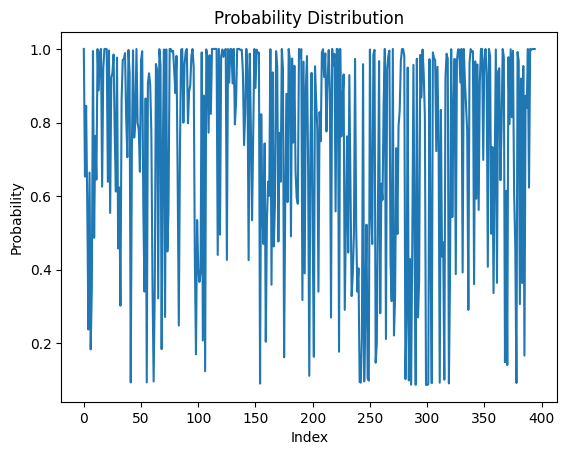

In [11]:
# seq_N810 = load_sequence("../processed_sequences/95_ID_Cluster_test/N810/grasp_seqs_N810.tsv")
# seq_N16 = load_sequence("../processed_sequences/95_ID_Cluster_test/N16/grasp_seqs_N16.tsv")
# seq_N17 = load_sequence("../processed_sequences/95_ID_Cluster_test/N17/grasp_seqs_N17.tsv")
seq_N66, probs_N66 = load_sequence("../processed_sequences/clustal_hmm_5_per_cluster_18022023/ancestors/seqs11_N1781.tsv")
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(probs_N66)
ax.set_xlabel('Index')
ax.set_ylabel('Probability')

# set the title
ax.set_title('Probability Distribution')

# display the plot
plt.show()


In [ ]:
print_alignment(seq_N17,grasp_seqs["N1420"].seq)

In [ ]:
SeqIO.write(SeqRecord(remove_gaps(seq_N18),id="N18",description=""), "../processed_sequences/95_ID_Cluster_test/N18.fasta", "fasta")

In [ ]:
print(f"iqtree2 -s $trimmed_sequences_filename {(redo_text if redo else "")} -T 47 -m $method {(asr_text if asr else "")} -abayes")




